# Multi Label Text Classification Using Keras + Cloud ML Engine 

<img src="assets/stackoverflow.jpg" style="width: 600px;">

#### This notebook will demonstrate the following steps:

1. Load Raw Data
2. Explore Data
3. Preprocess Data
4. Construct a model that learns to tag Stack Overflow posts
5. Use Cloud ML Engine's automatic hyperparameter tuning feature to refine the model
6. Inspect the results using tensorboard
7. And deploy the final model to production using Cloud ML Engine's online prediction service

This notebook is intended to be run on Google Cloud Datalab: https://cloud.google.com/datalab/docs/quickstarts
Datalab will have the required libraries installed by default for this code to work. If you choose to run this code outside of Datalab you may run in to version and dependency issues which you will need to resolve.

In [ ]:
!pip install --upgrade tensorflow==1.4

In [62]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import googleapiclient.discovery

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout
from tensorflow.python.keras.preprocessing import text, sequence
from tensorflow.python.keras import utils
from tensorflow.contrib.saved_model.python.saved_model.utils import simple_save

from collections import Counter

# This code was tested with TensorFlow v1.4
# The import statements will not work with earlier versions, because Keras is in tf.contrib in those versions
print("You have TensorFlow version", tf.__version__)

You have TensorFlow version 1.4.0


### 1) Load Raw Data

We will use a publically available dataset of Stack Overflow posts. It is hosted for free on Google's Big Query platform [here](https://bigquery.cloud.google.com/table/bigquery-public-data:stackoverflow.posts_questions?pli=1&tab=details).

We will extract a subset of this data using [this](https://bigquery.cloud.google.com/savedquery/38969729279:919b6f9f680b4cc6ace82632eeb357fd) query.

Datalab has a built-in library to easily load data from Big Query which we will use below. If you're not running from datalab an alternative way of downloading the data is provided in the subsequent cell.

In [68]:
import google.datalab.bigquery as bq

query = """
SELECT tags, TRIM(LOWER(REGEXP_REPLACE(CONCAT(title, \' \', body), r\'[\"\\n\\\'?,]|<p>|</p>\',\" \"))) as post 
FROM `bigquery-public-data.stackoverflow.posts_questions`
WHERE REGEXP_CONTAINS(tags, r\"javascript|java|c#|php|android|jquery|python\") 
LIMIT 1000
"""

data = bq.Query(query).execute(output_options=bq.QueryOutput.dataframe()).result()
NUM_ROWS = data.shape[0]
print("Loaded {} rows".format(NUM_ROWS))
data.head(10)

Loaded 1000 rows


,tags,post
0,c#,process.kill() related crashes or not! i h...
1,c#,c# how to put value outside of for looping i...
2,c#,reflectiontypeloadexception: unable to load on...
3,c#,how to change text in notepad in c# i have m...
4,c#,how to get indian currency format using c# i ...
5,c#,httpwebresponse send to web browser i am new...
6,php,$var instead of $_get[ var ] in php ok i can...
7,php,auto redirect from one url to another i want ...
8,php,populate select box with data from mysqltable ...
9,php,next_record called with no query pending i wa...


If you're running from a jupyter notebook on your laptop/workstation (as opposed to datalab) I've hosted the data as a static .CSV file in a publically accessible URL for convencience.

In [64]:
#alternative way to download data for non-datalab users

#data = pd.read_csv("https://storage.googleapis.com/vijay-public/text_classification/results-1000.csv")
#NUM_ROWS = data.shape[0]
#print("Loaded {} rows".format(NUM_ROWS))
#data.head()

### 2) Data Exploration 

For multi-label exploration it's useful to get an idea of the distribution of our labels. Here we will count the number of occurences of each of most common labels. 

In [65]:
#Generate list of N most common labels
NUM_CLASSES = 5
labels_list = []

counts = Counter('|'.join(data['tags'].tolist()).split('|'))
classes = counts.most_common(NUM_CLASSES)

for i in range(0,NUM_CLASSES):
    labels_list.append(classes[i][0])
    
print ("{} most common classes:".format(NUM_CLASSES))
classes

5 most common classes:


[(u'java', 204),
 (u'javascript', 193),
 (u'c#', 168),
 (u'php', 161),
 (u'android', 159)]

Since our ML algorithm will expect numbers as labels, not words, below we define utility function to switch back and forth between the human-friendly text and machine-friendly vector representation of the labels. 

In [66]:
#labels_list: A list of the valid classes
#tags: A list of tags for a post
#returns an ndarray with ones for the active classes
def labels_to_array(tags,labels_list=labels_list):
    array = np.zeros(len(labels_list),dtype=np.int8)
    tags = tags.split('|') #split tags from pipe separated string into list
    for tag in tags:
        try:
            array[labels_list.index(tag)] = 1
        except ValueError: 
            None
    return array

#translate machine readable array back to human labels
def array_to_labels(array, labels_list=labels_list, threshold = 1):
    labels = []
    i=0
    for flag in array:
        if flag >= threshold: 
            labels.append(labels_list[i])
        i=i+1
    return labels

#test utility functions
print(data['tags'][4])
array = labels_to_array(data['tags'][4])
print(array)
array_to_labels(array)

c#
[0 0 1 0 0]


[u'c#']

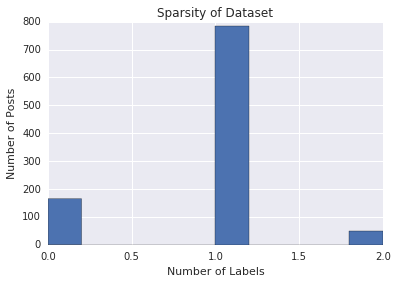

In [69]:
#Find label density
label_counts = np.zeros(NUM_ROWS)
for i in range(len(label_counts)):
    label_counts[i] = labels_to_array(data['tags'][i]).sum()
    
plt.xlabel('Number of Labels')
plt.ylabel('Number of Posts')
plt.title('Sparsity of Dataset')
plt.hist(label_counts)
plt.show()

### 3) Data Preprocessing

In [70]:
# Split data into train and test
train_size = int(len(data) * .8)
test_size = len(data)-train_size
print ("Train size: %d" % train_size)
print ("Test size: %d" % test_size)

Train size: 800
Test size: 200


In [71]:
train_posts = data['post'][:train_size]
train_tags = data['tags'][:train_size]

test_posts = data['post'][train_size:]
test_tags = data['tags'][train_size:]

In [72]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [73]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [74]:
# generate multi-label arrays
y_train = np.zeros([train_size,NUM_CLASSES])
for i in range(0,train_size):
    y_train[i] = labels_to_array(data['tags'][i])

y_test = np.zeros([test_size,NUM_CLASSES])
for i in range(0,test_size):
    y_test[i] = labels_to_array(data['tags'][i+train_size-1])
y_test[0]

array([ 0.,  0.,  1.,  0.,  0.])

In [75]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (800, 1000)
x_test shape: (200, 1000)
y_train shape: (800, 5)
y_test shape: (200, 5)


### 4) Model Code

In [76]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 32
epochs = 2

In [77]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('sigmoid')) #changed from softmax

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) #changed from categorical_crossentropy

In [78]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 720 samples, validate on 80 samples
Epoch 1/2
720/720 [==============================] - 1s - loss: 0.4955 - acc: 0.7917 - val_loss: 0.4150 - val_acc: 0.8300
Epoch 2/2
720/720 [==============================] - 0s - loss: 0.3347 - acc: 0.8608 - val_loss: 0.3537 - val_acc: 0.8350


In [79]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

 32/200 [===>..........................] - ETA: 0sTest score: 0.478361878395
Test accuracy: 0.815000042915


In [80]:
# Here's how to generate a prediction on individual examples locally
for i in range(5):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = array_to_labels(prediction[0],threshold=.5)
    print(test_posts.iloc[i][:200], "...")
    print('Actual label:' + '|'.join(array_to_labels(y_test[i])))
    print("Predicted label: " + '|'.join(predicted_label) + '\n')  

entity framework 4 and sql server 2008 multiple possible foreign keys  i am trying to come up with a database design that would work with entity framework 4 code first.  actually  i have no experience ...
Actual label:c#
Predicted label: 

ie: the incredible jumping table header  disclaimer: as it says in the title  this is targeted at internet explorer <b>only</b>. that s a perk of doing internal development - it makes life a little ea ...
Actual label:c#
Predicted label: 

javascript loop scope and buttons  so i would like to have a button dynamically created based on the element of an array but i run into errors when trying to pass arguments to the onclick function   < ...
Actual label:javascript
Predicted label: javascript

scaling an image with libgdx spritebatches  i have my image (for the sake of explaining  lets call it <code>image.png</code>) and i m trying to get it to scale to properly fit in my bodies i have draw ...
Actual label:javascript
Predicted label: 

design pattern

### 5) Package for ML Engine

In [81]:
%%bash
mkdir trainer
touch trainer/__init__.py

mkdir: cannot create directory ‘trainer’: File exists


In [103]:
%%writefile trainer/task.py

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools
import argparse
import json
import time
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import google.datalab.bigquery as bq

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout
from tensorflow.python.keras.preprocessing import text, sequence
from tensorflow.python.keras import utils

from collections import Counter

print("You have TensorFlow version", tf.__version__)

# Hyperparamters for tuning
parser = argparse.ArgumentParser()
# Input Arguments
parser.add_argument(
  '--train_batch_size',
  help='Batch size for training steps',
  type=int,
  default=32
)
parser.add_argument(
  '--epochs',
  help='Number of epochs to train for',
  type=int,
  default=2
)
parser.add_argument(
      '--output_dir',
      help='GCS location to write checkpoints and export models',
      required=True
)
parser.add_argument(
        '--job-dir',
        help='this model ignores this field, but it is required by gcloud',
        default='junk'
)
args = parser.parse_args()

#Download CSV
query = """
SELECT tags, TRIM(LOWER(REGEXP_REPLACE(CONCAT(title, \' \', body), r\'[\"\\n\\\'?,]|<p>|</p>\',\" \"))) as post 
FROM `bigquery-public-data.stackoverflow.posts_questions`
WHERE REGEXP_CONTAINS(tags, r\"javascript|java|c#|php|android|jquery|python\") 
LIMIT 1000
"""

#data = bq.Query(query).execute(output_options=bq.QueryOutput.dataframe()).result() #issues with ML Engine service account authentication
data = pd.read_csv("https://storage.googleapis.com/vijay-public/text_classification/results-1000.csv")
NUM_ROWS = data.shape[0]
print("Loaded {} rows".format(NUM_ROWS))

#Generate list of N most common labels
NUM_CLASSES = 5
labels_list = []

counts = Counter('|'.join(data['tags'].tolist()).split('|'))
classes = counts.most_common(NUM_CLASSES)

for i in range(0,NUM_CLASSES):
    labels_list.append(classes[i][0])
    
print ("{} most common classes:".format(NUM_CLASSES))
print(classes)

#utility functions to extract classes and translate between 
#human friendly (string) labels and machine friendly (array) labels

#labels_list: A list of the valid classes
#tags: A list of tags for a post
#returns an ndarray with ones for the active classes
def labels_to_array(tags,labels_list=labels_list):
    array = np.zeros(len(labels_list),dtype=np.int8)
    tags = tags.split('|') #split tags from pipe separated string into list
    for tag in tags:
        try:
            array[labels_list.index(tag)] = 1
        except ValueError: 
            None
    return array

#translate machine readable array back to human labels
def array_to_labels(array, labels_list=labels_list, threshold = 1):
    labels = []
    i=0
    for flag in array:
        if flag >= threshold: 
            labels.append(labels_list[i])
        i=i+1
    return labels

### DATA PREPROCESSING ### 
train_size = int(len(data) * .8)
test_size = len(data)-train_size
print ("Train size: %d" % train_size)
print ("Test size: %d" % test_size)

train_posts = data['post'][:train_size]
train_tags = data['tags'][:train_size]

test_posts = data['post'][train_size:]
test_tags = data['tags'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

# generate multi-label arrays
y_train = np.zeros([train_size,NUM_CLASSES])
for i in range(0,train_size):
    y_train[i] = labels_to_array(data['tags'][i])

y_test = np.zeros([test_size,NUM_CLASSES])
for i in range(0,test_size):
    y_test[i] = labels_to_array(data['tags'][i+train_size-1])
y_test[0]

# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

### BUILD MODEL ###
#Set hyperparameters
batch_size = args.train_batch_size
epochs = args.epochs


model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
#model.add(Dropout(0.5)) #this breaks SavedModel prediction
model.add(Dense(NUM_CLASSES))
model.add(Activation('sigmoid')) #changed from softmax

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) #changed from categorical_crossentropy

# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting


#Enable Tensorboard logging
Tensorboard = tf.keras.callbacks.TensorBoard(log_dir=args.output_dir + "/tensorboard")

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[Tensorboard]) #callback for Tensorboard

# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])


# Here's how to generate a prediction on individual examples
for i in range(5):
    prediction = model.predict(np.array([x_test[i]]))
    #print(prediction[0])
    #print(y_test[i])
    predicted_label = array_to_labels(prediction[0],threshold=.5)
    print(test_posts.iloc[i][:200], "...")
    print('Actual label:' + '|'.join(array_to_labels(y_test[i])))
    print("Predicted label: " + '|'.join(predicted_label) + '\n') 
    
### EXPORT MODEL ### 
model_builder = tf.saved_model.builder.SavedModelBuilder(args.output_dir+"/export/"+time.strftime("%Y%m%d-%H%M%S"))

inputs = {'input': tf.saved_model.utils.build_tensor_info(model.input)}
outputs = {'output': tf.saved_model.utils.build_tensor_info(model.output)}

signature_def = tf.saved_model.signature_def_utils.build_signature_def(
    inputs=inputs,
    outputs=outputs,
    method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME
)

model_builder.add_meta_graph_and_variables(
    tf.keras.backend.get_session(),
    tags=[tf.saved_model.tag_constants.SERVING],
    signature_def_map={
        tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature_def
    }
)

model_builder.save()

Overwriting trainer/task.py


In [104]:
%%bash
gcloud ml-engine local train \
   --module-name=trainer.task \
   --package-path=trainer \
   -- \
   --output_dir='./output'

You have TensorFlow version 1.4.0
Loaded 1000 rows
5 most common classes:
[('javascript', 376), ('java', 334), ('jquery', 133), ('c#', 100), ('html', 82)]
Train size: 800
Test size: 200
x_train shape: (800, 1000)
x_test shape: (200, 1000)
y_train shape: (800, 5)
y_test shape: (200, 5)
Train on 720 samples, validate on 80 samples
Epoch 1/2
720/720 [==============================] - 1s - loss: 0.4513 - acc: 0.8142 - val_loss: 0.3396 - val_acc: 0.8950
Epoch 2/2
 32/200 [===>..........................] - ETA: 0sTest score: 0.672376728058
update single record with an array of results  a query leads to a list of results (@invoice_results - - also the name of the controller action) with two specific columns in the view (formatting remove ...
Actual label:javascript|c#
Predicted label: 

jquery and mouseevents  i have a question regarding mouse events in the jquery library. i have a simple javascript function as following:   <pre><code>$(function() {     var xpos;     var ypos;     $( ...
Actu

2017-11-12 20:31:59.257189: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [105]:
GCS_BUCKET = 'gs://vijays-sandbox-ml' #CHANGE THIS TO YOUR BUCKET
PROJECT = 'vijays-sandbox' #CHANGE THIS TO YOUR PROJECT ID
REGION = 'us-central1' #OPTIONALLY CHANGE THIS

In [106]:
import os
os.environ['GCS_BUCKET'] = GCS_BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

### 6) Use Cloud ML Engine to automate hyperparameter tuning

In [107]:
%%writefile config.yaml
trainingInput:
  hyperparameters:
    goal: MAXIMIZE
    hyperparameterMetricTag: val_acc
    maxTrials: 1
    maxParallelTrials: 1
    params:
    - parameterName: train_batch_size
      type: INTEGER
      minValue: 1
      maxValue: 1000
      scaleType: UNIT_LINEAR_SCALE

Overwriting config.yaml


#### Upgrade ML Engine Tensorflow Version

Our code requires TF 1.4, however TF 1.4 is not yet a pre-packaged runtime for ML Engine. However we can force the installation of TF 1.4 by specifying it as a PyPi dependency as documented [here](https://cloud.google.com/ml-engine/docs/versioning#specifying_custom_versions_of_tensorflow_for_training)

In [108]:
%%writefile setup.py
from setuptools import find_packages
from setuptools import setup

REQUIRED_PACKAGES = ['tensorflow==1.4','datalab']

setup(
    name='trainer',
    version='0.1',
    install_requires=REQUIRED_PACKAGES,
    packages=find_packages(),
    include_package_data=True,
    description='Text Classification Trainer Application')

Overwriting setup.py


#### Queue ML Engine Training Job

We use the gcloud command line tool to do so

In [110]:
%%bash
JOBNAME=text_classification_$(date -u +%y%m%d_%H%M%S)

gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --runtime-version=1.2 \
   --module-name=trainer.task \
   --package-path=trainer \
   --job-dir=$GCS_BUCKET/$JOBNAME/ \
   --config config.yaml \
   -- \
   --output_dir=$GCS_BUCKET/$JOBNAME/output

jobId: text_classification_171112_203653
state: QUEUED


Job [text_classification_171112_203653] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe text_classification_171112_203653

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs text_classification_171112_203653


### 7) Inspect Results Using TensorBoard

In [89]:
from google.datalab.ml import TensorBoard
TensorBoard().start('output')

TensorBoard was started successfully with pid 7530. Click here to access it.

7530

If you're running from a jupyter notebook on your laptop/workstation (as opposed to datalab) you can use the below command instead to launch tensorboard

When you're done with tensorboard interrupt the kernel (using the Jupyter menu bar) to quit

In [ ]:
#alternative tensorboard command for outside datalab

#!tensorboard --logdir=output/

### 8) Deploy For Prediction

Cloud ML Engine has a prediction service that will wrap our tensorflow model with a REST API and allow remote clients to get predictions.

You can deploy the model from the Google Cloud Console GUI, or you can use the gcloud command line tool. We will use the latter method.

In [ ]:
%%bash
MODEL_NAME="text_classification"
MODEL_VERSION="v1_1000_word_embedding"
MODEL_LOCATION="output/export/20171110-135219" #REPLACE this with the location of your model

#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME} #Uncomment to overwrite existing version
#gcloud ml-engine models delete ${MODEL_NAME} #Uncomment to overwrite existing model
gcloud ml-engine models create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --staging-bucket=$GCS_BUCKET

### 9) Get Predictions
There are two flavors of the ML Engine Prediction Service: Batch and online.

Online prediction is more appropriate for latency sensitive requests as results are returned quickly and synchronously.

Batch prediction is more appropriate for large prediction requests that you only need to run a few times a day.

Below we define a function that takes care of
1. Authenticating to the Google Cloud API
2. Converting our post text to the vector embedding the model was trained on
3. Passes this embedding in JSON format, which is what the API expects

In [ ]:
def predict_json(project, model, post, version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the Cloud ML Engine Model is deployed.
        model (str): model name.
        post: str, the text you want to classify.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """

    # Convert post to vector embedding
    instances = tokenize.texts_to_matrix([post]).tolist()
    # Authenticate
    # GOOGLE_APPLICATION_CREDENTIALS=<path_to_service_account_file>
    # OR: gcloud auth application-default login
    service = googleapiclient.discovery.build('ml', 'v1')
    
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

Now we'll call the prediction function and get results! Try modifying the post text to see how it affects the label scores. Does it behave how you would expect?

In [ ]:
POST = "java is my world"
MODEL = "text_classification"
VERSION = "v1_1000_word_embedding"

response = predict_json(PROJECT,MODEL,POST,VERSION)[0].get('output')

print("Post: {} \nLabel Scores: {} \nLabels:{} \nLabels above threshold:{}".format(
    POST,response,labels_list,array_to_labels(response,threshold=0.5)))